In [1]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from calendar import monthrange
from matplotlib.dates import date2num, num2date
import h5py
from sklearn import decomposition
import nimfa
from scipy import signal

import matplotlib.pyplot as plt
# from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
%matplotlib inline

In [3]:
save_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_new/'
save_fname = '20150817-20151017_MVBS.h5'

f = h5py.File(os.path.join(save_path,save_fname),"r")
MVBS = np.array(f['MVBS'])

In [4]:
ping_per_day_mvbs = 144

*************************
## Functions for plotting

In [5]:
def plot_comp(V,figsize_input,save_fname='test.png',log_opt=1):
    fig,ax=plt.subplots(n_comp,1,sharex=True,figsize=figsize_input)
    for c in range(n_comp):
        if log_opt==1:
            vlog = 10*np.ma.log10(V[c,:,:])
        else:
            vlog = V[c,:,:]
        cmean = np.mean(vlog)
        cstd = np.std(vlog)
        cmin = max((np.min(vlog),cmean-2*cstd))
        cmax = min((np.max(vlog),cmean+4*cstd))
        im = ax[c].imshow(vlog,aspect='auto',vmin=cmin,vmax=cmax)
        divider = make_axes_locatable(ax[c])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im,cax=cax)

        ax[c].set_xticks([x*ping_per_day_mvbs+ping_per_day_mvbs/2 for x in range(3)])
        ax[c].set_xticklabels(['38k','120k','200k'])
        ax[c].tick_params('both', length=0)
    plt.savefig(os.path.join(save_path,save_fname))

In [6]:
def plot_coef(W,yscale=0,save_fname='test.png'):
    plt.figure(figsize=(22,3))
    W[W==0] = sys.float_info.epsilon
    labels = [str(x) for x in range(n_comp)]
    for w, label in zip(W.T, labels):
        plt.plot(range(1,len(w)+1),w, label=label,linewidth=2)
    plt.legend()
    plt.xticks(range(mvbs_long.shape[0]))
    if yscale==1:
        plt.yscale('log')
    plt.xlim([0,mvbs_long.shape[0]])
    plt.savefig(os.path.join(save_path,save_fname))
    plt.show()

In [110]:
def plot_cmp_data_decomp(V,X,plot_day,figsize_input,save_fname='test.png',same_cax_opt=1):
    plot_range_day = 1
    fig,ax = plt.subplots(2,3,figsize=figsize_input)
    for iY in range(2):
        # Get color axis limtis
        v_mtx = V[:,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].reshape((-1,1))
        cmean = np.mean(v_mtx)
        cstd = np.std(v_mtx)
        cmax = np.max(v_mtx)

        for iX in range(3):
            if iY==0:
                v = V[iX,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]   # data to be plotted
            else:
                v = X[iX,:,ping_per_day_mvbs*(plot_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)]   # data to be plotted

            if same_cax_opt==1:
                im = ax[iY,iX].imshow(v.T,aspect='auto',vmax=cmean+cstd*6,vmin=cmean-cstd*3)#,cmap=e_cmap,norm=e_norm)
            else:
                im = ax[iY,iX].imshow(v.T,aspect='auto')#,cmap=e_cmap,norm=e_norm)
            divider = make_axes_locatable(ax[iY,iX])
            cax = divider.append_axes("right", size="2%", pad=0.1)
            cbar = plt.colorbar(im,cax=cax)
            if iX==0:
                ax[iY,iX].set_title('38 kHz')
            elif iX==1:
                ax[iY,iX].set_title('120 kHz')
            else:
                ax[iY,iX].set_title('200 kHz')
    plt.savefig(os.path.join(save_path,save_fname))

In [8]:
def plot_original_echogram(plot_start_day,plot_range_day):
#     plot_start_day = 42
#     plot_range_day = 10
    fig,ax = plt.subplots(3,1,figsize=(15,6))
    ax[0].imshow(MVBS[0,1:-2,ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',vmin=-80,vmax=-30)#,cmap=e_cmap,norm=e_norm)
    ax[1].imshow(MVBS[1,1:-2,ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',vmin=-80,vmax=-30)#,cmap=e_cmap,norm=e_norm)
    ax[2].imshow(MVBS[2,1:-2,ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',vmin=-80,vmax=-30)#,cmap=e_cmap,norm=e_norm)
    ax[2].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
    ax[2].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
    ax[2].set_xlabel('Day',fontsize=14)
    plt.show()

In [9]:
def separate_transform(D,ori_data,log_opt=1):
    D_long = D.reshape((D.shape[0],-1,ori_data.shape[1])).swapaxes(1,2)
    D_sep = D_long.reshape((D_long.shape[0],D_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
    if log_opt==1:
        D_plot = 10*np.log10(D_sep.transpose((0,2,1,3))).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    else:
        D_plot = D_sep.transpose((0,2,1,3)).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    return D_sep,D_plot

******************************************
## NIMFA decomposition

In [10]:
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
# mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [11]:
MVBS_copy = np.copy(MVBS[:,1:-2,:-3*ping_per_day_mvbs])
# MVBS_copy = np.copy(MVBS[:,1:-2,:])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

In [54]:
n_comp = 5

nmf_lin = nimfa.Nmf(mvbs_long,rank=n_comp,update='divergence',objective='div',n_run=10)
nmf_lin_fit = nmf_lin()
W_nmf_lin = np.array(nmf_lin_fit.basis())
H_nmf_lin = np.array(nmf_lin_fit.coef())
V_nmf_lin = H_nmf_lin.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_nmf_lin = np.dot(W_nmf_lin,H_nmf_lin)
D_nmf_lin_sep,D_nmf_lin_plot = separate_transform(D_nmf_lin,mvbs,log_opt=0)

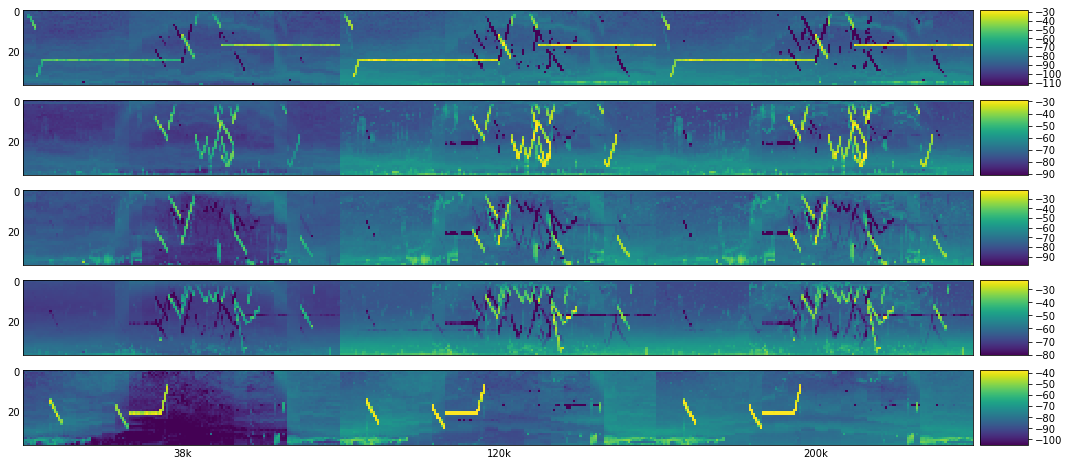

In [55]:
plot_comp(V_nmf_lin,figsize_input=(18,8),save_fname='59days_nimfa_nmf_lin_5comp.png',log_opt=1)

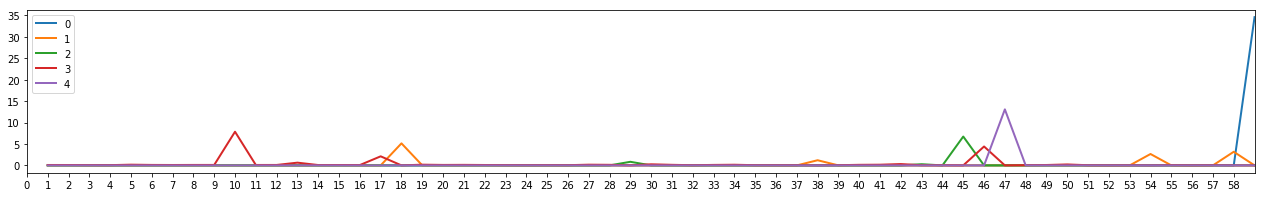

In [56]:
plot_coef(W_nmf_lin,yscale=0,save_fname='test.png')

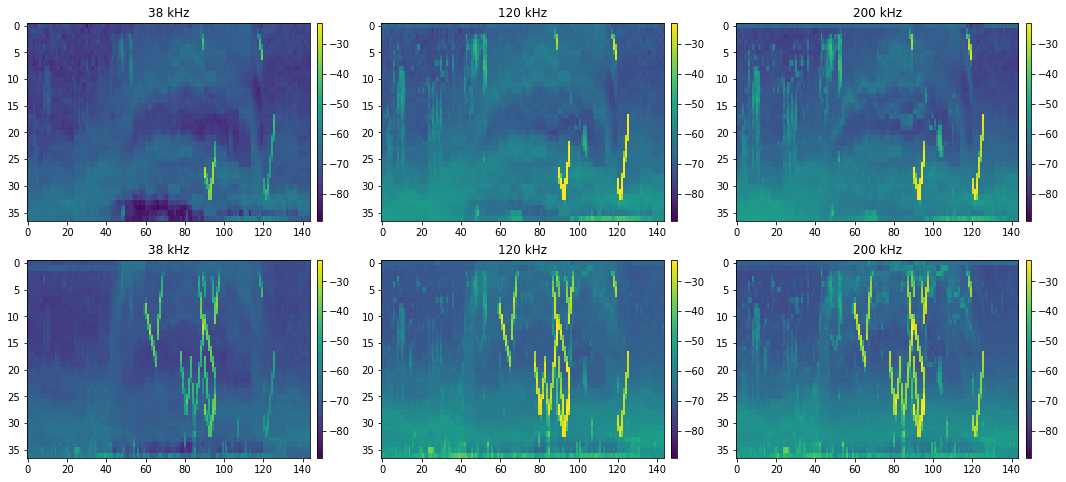

In [66]:
plot_day = 58
plot_cmp_data_decomp(MVBS,10*np.log10(D_nmf_lin_plot),plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

In [98]:
n_comp = 5

nmf_log = nimfa.Nmf(MVBS_long-MVBS_long.min(),rank=n_comp,update='divergence',objective='div',max_iter=1000,n_run=10)
nmf_log_fit = nmf_log()
W_nmf_log = np.array(nmf_log_fit.basis())
H_nmf_log = np.array(nmf_log_fit.coef())
V_nmf_log = H_nmf_log.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [100]:
D_nmf_log = np.dot(W_nmf_log,H_nmf_log)
D_nmf_log_sep,D_nmf_log_plot = separate_transform(D_nmf_log,mvbs,log_opt=0)

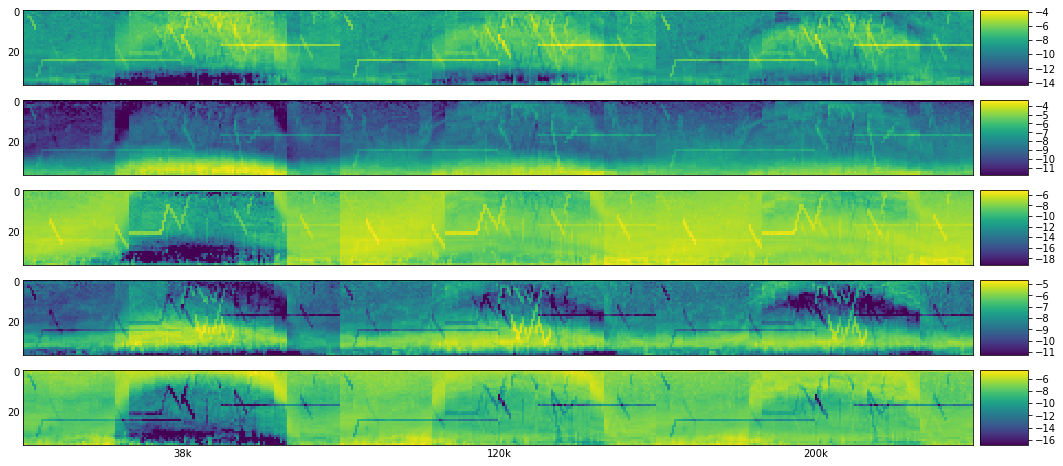

In [101]:
plot_comp(V_nmf_log,figsize_input=(18,8),save_fname='59days_nimfa_nmf_log_5comp.png',log_opt=1)

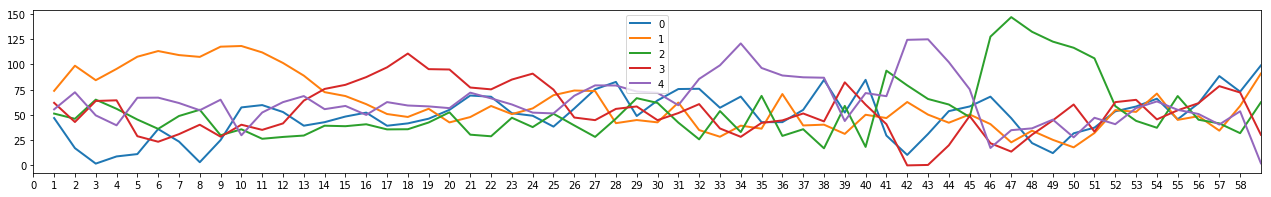

In [103]:
plot_coef(W_nmf_log,yscale=0,save_fname='test.png')

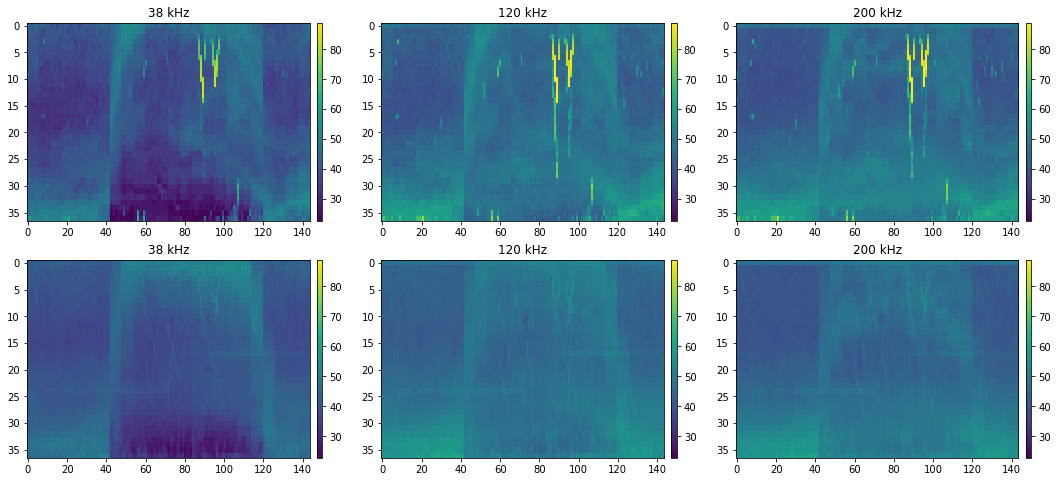

In [111]:
plot_day = 38
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

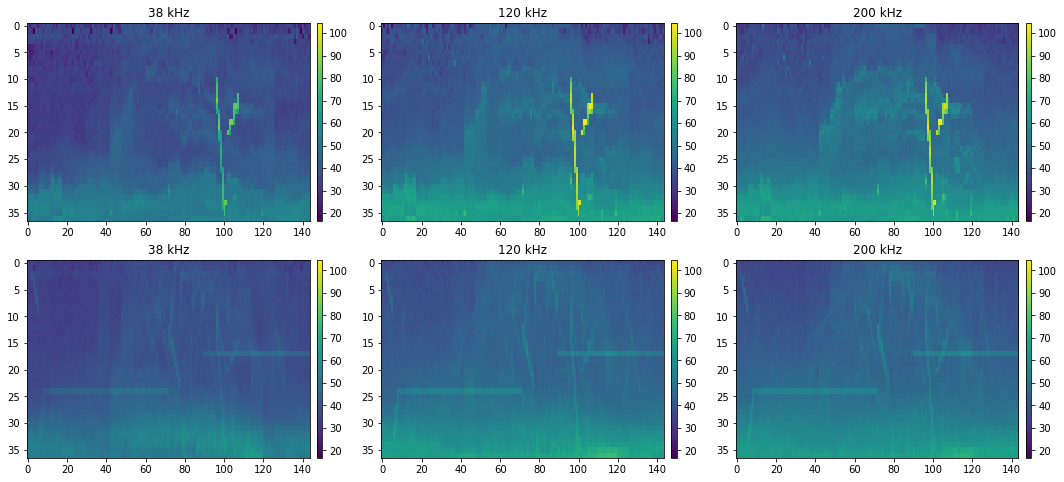

In [112]:
plot_day = 10
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

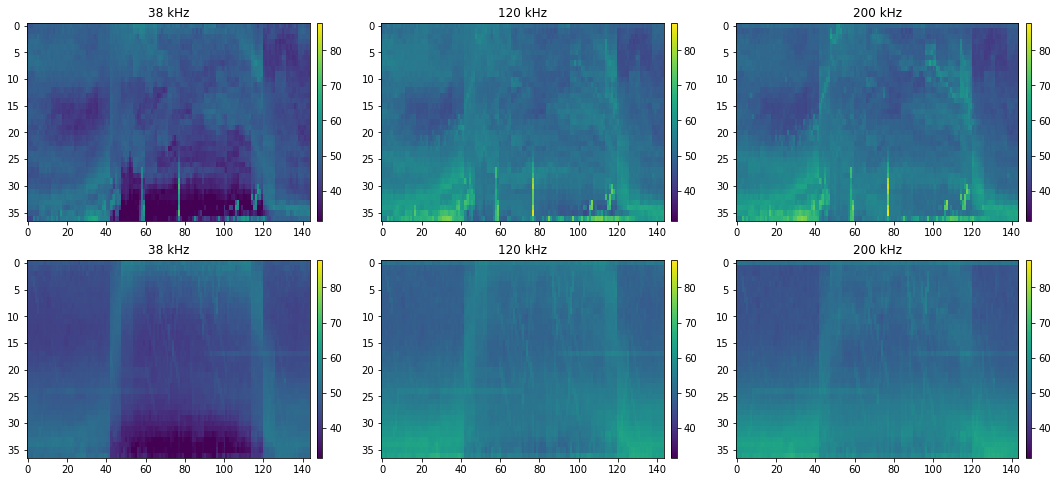

In [113]:
plot_day = 28
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

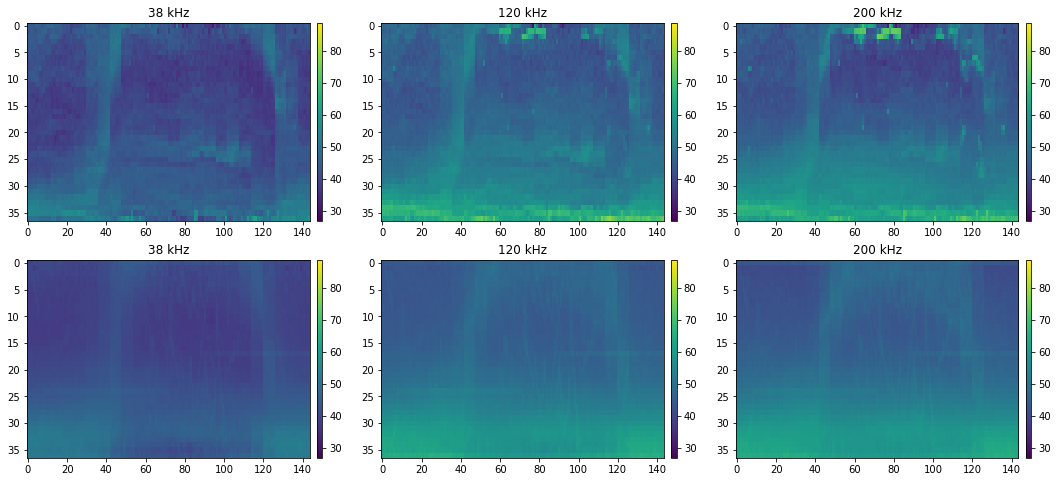

In [134]:
plot_day = 1
plot_cmp_data_decomp(MVBS_copy-MVBS_copy.min(),D_nmf_log_plot,plot_day,figsize_input=(18,8),save_fname='test.png',same_cax_opt=1)

**************************************
## Thoughts...
The log-domain NMF using NIMFA seems to separate out the profiler echoes better and the reconstructed echograms are much more _low-ranked_. What about reconstruct the whole thing in log-domain, transform it back to the linear domain, and do linear-domain NMF on it?

In [107]:
D_nmf_log_plot.shape

(3, 37, 8496)

In [109]:
MVBS_copy.shape

(3, 37, 8496)

Get `MVBS_copy` into the same format as `D_nmf_log_sep` for plotting.

In [129]:
MVBS_sep,_ = separate_transform(MVBS_long,mvbs,log_opt=0)

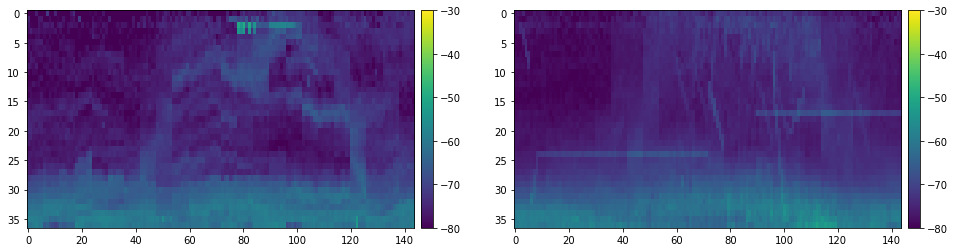

In [144]:
plot_day = 10
plot_freq = 0

fig,ax = plt.subplots(1,2,figsize=(16,4))

im = ax[0].imshow(MVBS_sep[plot_freq,plot_day,:,:],aspect='auto',vmin=-80,vmax=-30)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="3%", pad=0.1)
cbar = plt.colorbar(im,cax=cax)

im = ax[1].imshow(D_nmf_log_sep[plot_freq,plot_day,:,:]+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="3%", pad=0.1)
cbar = plt.colorbar(im,cax=cax)

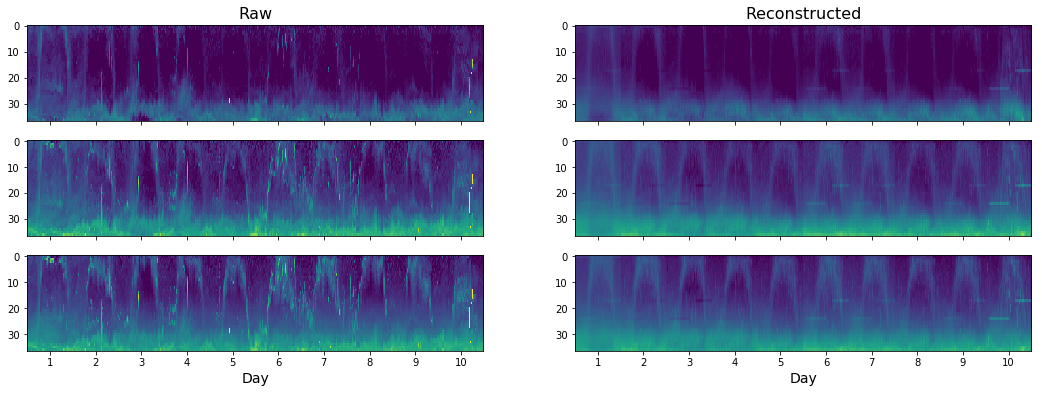

In [169]:
plot_start_day = 1
plot_range_day = 10
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(2):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Raw',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

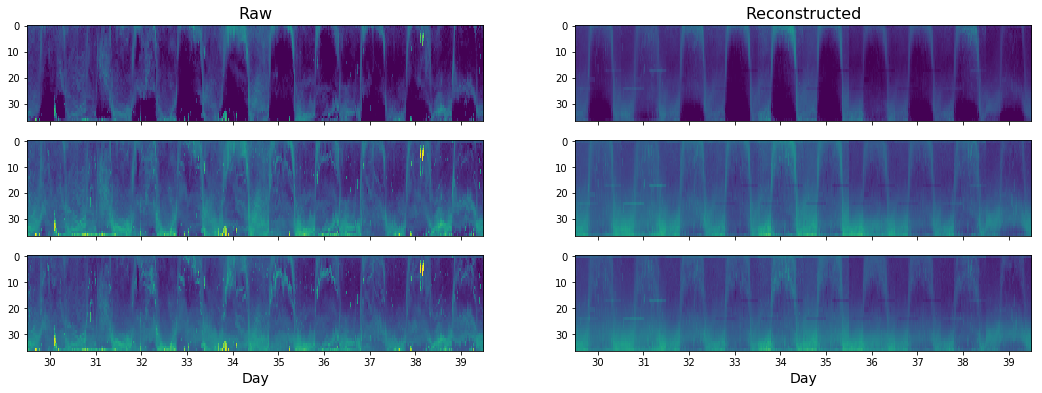

In [170]:
plot_start_day = 30
plot_range_day = 10
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(2):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Raw',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()

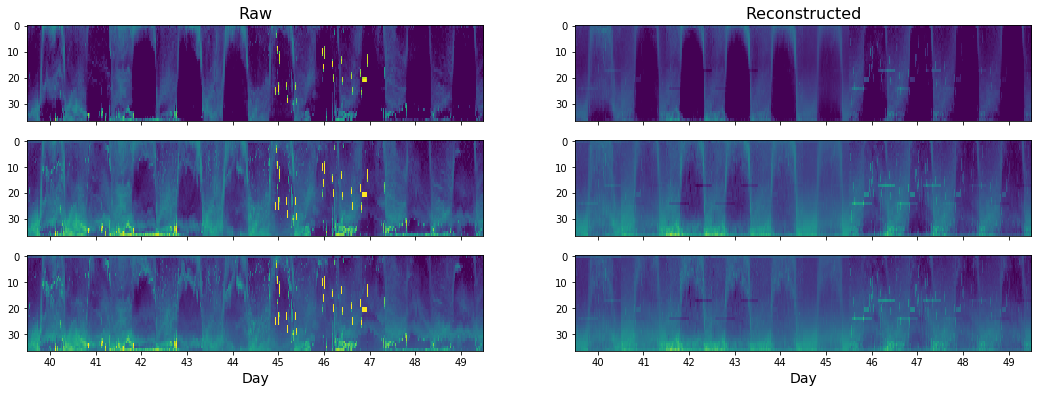

In [171]:
plot_start_day = 40
plot_range_day = 10
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True)
idx = ping_per_day_mvbs*(plot_start_day-1)+np.arange(ping_per_day_mvbs*plot_range_day)
for iX in range(2):
    for iY in range(3):
        if iX==0:
            im = ax[iY,iX].imshow(MVBS_copy[iY,:,idx].T,aspect='auto',vmin=-80,vmax=-30)
        else:
            im = ax[iY,iX].imshow(D_nmf_log_plot[iY,:,idx].T+MVBS_copy.min(),aspect='auto',vmin=-80,vmax=-30)
        if iY==0:
            if iX==0:
                ax[iY,iX].set_title('Raw',fontsize=16)
            else:
                ax[iY,iX].set_title('Reconstructed',fontsize=16)
        if iY==2:
            ax[iY,iX].set_xticks(np.arange(plot_range_day)*ping_per_day_mvbs+ping_per_day_mvbs/2)
            ax[iY,iX].set_xticklabels(np.arange(plot_range_day)+plot_start_day)
            ax[iY,iX].set_xlabel('Day',fontsize=14)
plt.show()